<h1> Титаник <span class="tocSkip"></span></h1>

<h1> Задача: <span class="tocSkip"></span></h1>

Поработать с датасетом Titanic с kaggle. Да, куда же без классики. =)

Ссылка на соревнование: https://www.kaggle.com/competitions/titanic/data?select=train.csv

Осуществить предобработку, обучить несколько моделей на тренировочной выборке, проверить на тестовой, сделать выводы.

Выполнить submission в соревновании на kaggle.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

from google.colab import drive

!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 KB 10.0 MB/s eta 0:00:00


# Загрузка и первичный осмотр данных

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/titanic/train.csv')


In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_train.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

# Предобработка на скорую руку

Видим, что в столбце Cabin очень много пропусков, больше 77 %. Удалим этот столбец. Также удалим столбцы PassengerId, Name, Ticket тк они не несут смысловой нагрузки. Остальные столбцы пока оставим. 

## Удаление избыточных признаков

In [7]:
df_train = df_train.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin'])
df_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [8]:
df_train = df_train[df_train['Embarked'].isna() == False]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


Остались пропуски в столбце возраста. И пропусков довольно много. Попробуем что-то с этим сделать. 

## Корреляция

Посмотрим матрицу корреляции между признаками.

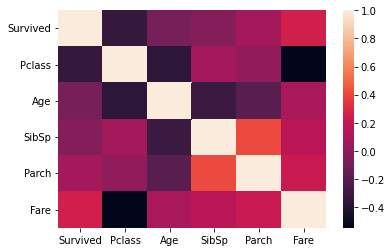

In [9]:
corr = df_train.corr() 
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values) 
plt.show()

Зависимости  между данными не найдено. 

Посмотрим распределение возрастов. 

## Пропуски в AGE

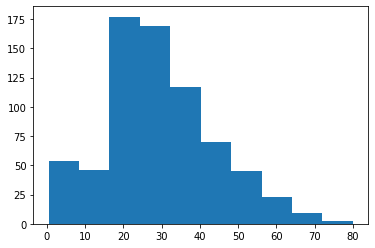

In [10]:
plt.hist(df_train['Age'])
plt.show()

Заменим пропуски в столбце Age на 100.

In [11]:
df_train["Age"] = df_train["Age"].fillna(-1)

In [12]:
df_train["Age"] = df_train['Age'].transform(lambda x: x.round()).astype('int16')

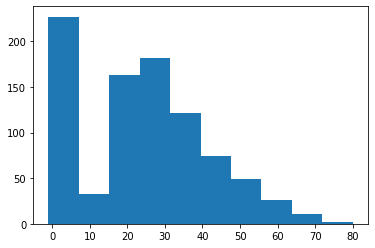

In [13]:
plt.hist(df_train['Age'])
plt.show()

In [14]:
'''df_train["M_Age"] = np.where(
     df_train["Age"].between(0, 20, inclusive=False),
    10,
    np.where(
     df_train["Age"].between(20, 30, inclusive=False),
    25,
    np.where(
     df_train["Age"].between(30, 40, inclusive=False),
    35,
     np.where(
        df_train["Age"].between(40, 50, inclusive=False), 
    45, 
    np.where(
        df_train["Age"].between(50, 60, inclusive=False), 
    55, 
    np.where(
        df_train["Age"].between(60, 70, inclusive=False), 
    65, 
    np.where(
        df_train["Age"].between(70, 80, inclusive=False), 
    75, 80

     ) ) ) ) ) )
) '''

'df_train["M_Age"] = np.where(\n     df_train["Age"].between(0, 20, inclusive=False),\n    10,\n    np.where(\n     df_train["Age"].between(20, 30, inclusive=False),\n    25,\n    np.where(\n     df_train["Age"].between(30, 40, inclusive=False),\n    35,\n     np.where(\n        df_train["Age"].between(40, 50, inclusive=False), \n    45, \n    np.where(\n        df_train["Age"].between(50, 60, inclusive=False), \n    55, \n    np.where(\n        df_train["Age"].between(60, 70, inclusive=False), \n    65, \n    np.where(\n        df_train["Age"].between(70, 80, inclusive=False), \n    75, 80\n\n     ) ) ) ) ) )\n) '

In [15]:
df_train = df_train[df_train['Age'].isna() == False]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    int16  
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(1), int16(1), int64(4), object(2)
memory usage: 57.3+ KB


## Ящики с усами по числовым признакам

Построим ящики с усами для количественных признаков

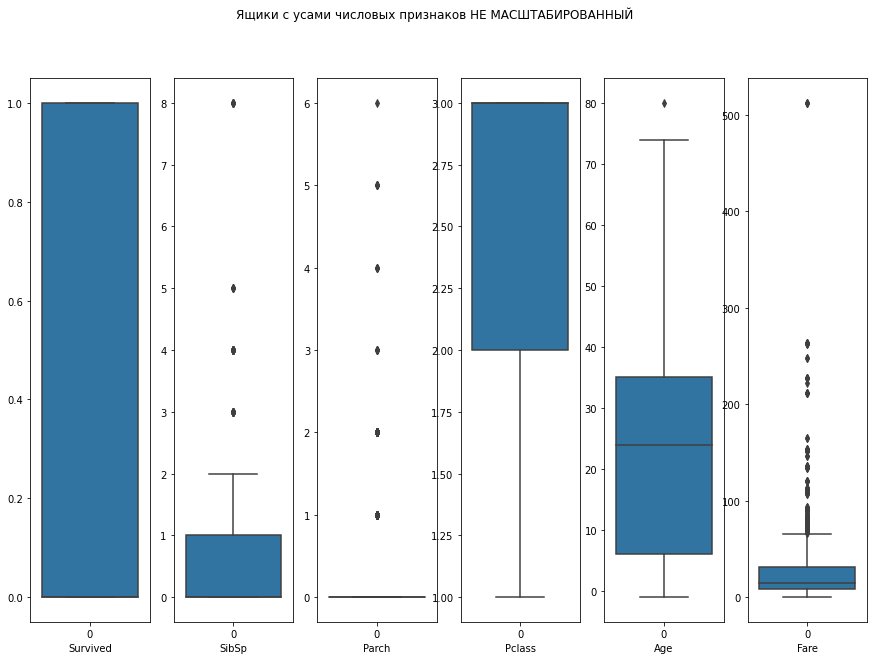

In [16]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(15,10)) #, sharey=True)
sns.boxplot(data=df_train['Survived'],  ax=ax1) 
sns.boxplot(data=df_train['SibSp'], ax=ax2) 
sns.boxplot(data=df_train['Parch'], ax=ax3) 
sns.boxplot(data=df_train['Pclass'], ax=ax4)  
sns.boxplot(data=df_train['Age'], ax=ax5) 
sns.boxplot(data=df_train['Fare'], ax=ax6) 


ax1.set_xlabel('Survived'), ax1.set_ylabel('')
ax2.set_xlabel('SibSp'), ax2.set_ylabel('')
ax3.set_xlabel('Parch'), ax3.set_ylabel('')
ax4.set_xlabel('Pclass'), ax4.set_ylabel('')
ax5.set_xlabel('Age'), ax5.set_ylabel('')
ax6.set_xlabel('Fare'), ax6.set_ylabel('')

plt.suptitle('Ящики с усами числовых признаков НЕ МАСШТАБИРОВАННЫЙ')
plt.show()

In [17]:
col_cols = set(df_train.columns) - set(['Sex', 'Embarked'])
cat_cols = set(df_train.columns) - set(col_cols)

Посмотрим на выбросы. Насколько они адекватны. 

SibSp — это число братьев, сестер или супругов на борту у человека.

In [18]:
df_train['SibSp'].value_counts()

0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Хорошо, цифры вполне реальны. Оставим как есть. 

Parch - это количество родителей / детей на борту.

In [19]:
df_train['Parch'].value_counts()

0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Ок, тоже оставим как есть.

Посмотрим на плату за проезд.

In [20]:
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22,1,0,7.2500,S
1,1,1,female,38,1,0,71.2833,C
2,1,3,female,26,0,0,7.9250,S
3,1,1,female,35,1,0,53.1000,S
4,0,3,male,35,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27,0,0,13.0000,S
887,1,1,female,19,0,0,30.0000,S
888,0,3,female,-1,1,2,23.4500,S
889,1,1,male,26,0,0,30.0000,C


In [21]:
df_train = df_train[df_train['Fare'] < 100]

Допустим, что кто-то платил очень много. Все это пассажиры первого класса, так что пусть останется все как есть. 

## Гистограммы категориальных признаков

Построим гистограммы категориальных признаков.

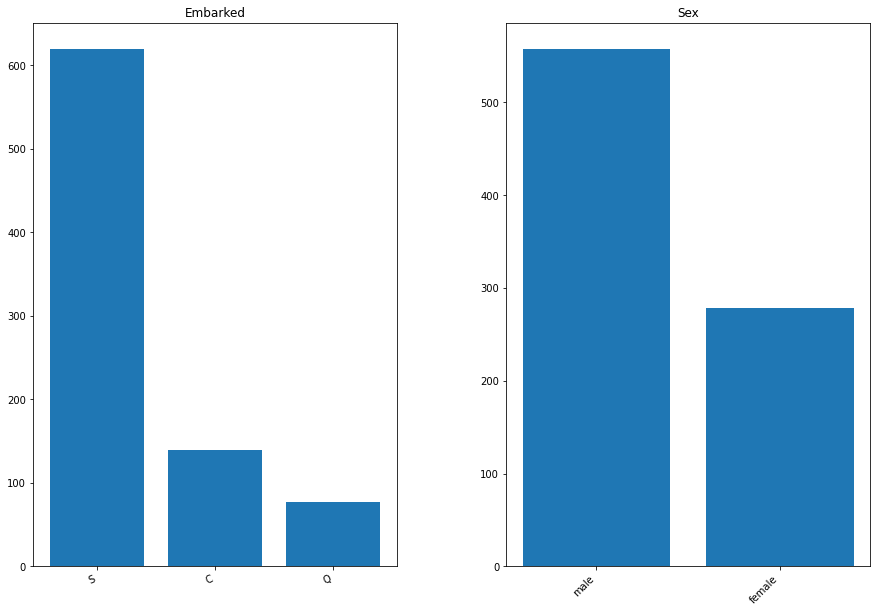

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

ax = ax.ravel()
j = 0
for i in cat_cols:
    
    ax[j].set_title(f'{i}')
    ax[j].bar(x = df_train[i].value_counts().index, height = df_train[i].value_counts().values)
                  
    labels = ax[j].get_xticklabels()
    plt.setp(labels, rotation = 25, horizontalalignment = 'right')
    plt.xticks(rotation=45) 
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    j +=1
    
fig.show()

## Удаление дубликатов

In [23]:
df_train= df_train.drop_duplicates()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  722 non-null    int64  
 1   Pclass    722 non-null    int64  
 2   Sex       722 non-null    object 
 3   Age       722 non-null    int16  
 4   SibSp     722 non-null    int64  
 5   Parch     722 non-null    int64  
 6   Fare      722 non-null    float64
 7   Embarked  722 non-null    object 
dtypes: float64(1), int16(1), int64(4), object(2)
memory usage: 46.5+ KB


## Распределение целевого признака

Посмотрим на распределение целевого признака. 

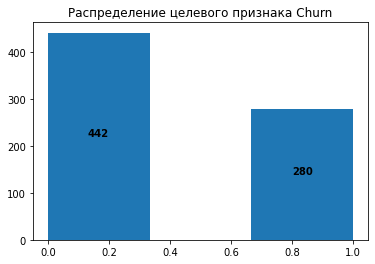

In [24]:
plt.hist(df_train['Survived'], bins = 3)
plt.title('Распределение целевого признака Churn')
plt.text(0.13, df_train['Survived'].value_counts()[0]/2, df_train['Survived'].value_counts()[0], color='black', fontweight='bold')
plt.text(0.80, df_train['Survived'].value_counts()[1]/2, df_train['Survived'].value_counts()[1], color='black', fontweight='bold')
plt.show()

Видим, что классы более менее сбалансированы.

## Кодирование категориальных признаков

Произведем кодирование категориальных признаков. Для CatBoost не будем производить кодирование, тк там оно встроено, поэтому создадим копию датасета. 

In [25]:
df_catboost = df_train.copy()
df_catboost.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22,1,0,7.2500,S
1,1,1,female,38,1,0,71.2833,C
2,1,3,female,26,0,0,7.9250,S
3,1,1,female,35,1,0,53.1000,S
4,0,3,male,35,0,0,8.0500,S


In [26]:
df_train = pd.get_dummies(df_train,drop_first=True)
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22,1,0,7.2500,1,0,1
1,1,1,38,1,0,71.2833,0,0,0
2,1,3,26,0,0,7.9250,0,0,1
3,1,1,35,1,0,53.1000,0,0,1
4,0,3,35,0,0,8.0500,1,0,1


## Вывод

Вывод:
Была проведена небольшая преобработка данных, а именно:
1. удаление избыточных признаков, 
2. удаление некоторых строк с пропусками, 
3. замена пропусков у признака возраст на значение 100, 
4. изменение типов данных,
5. удаление дубликатов,
6. кодирование категориальных признаков.

# Разделение на выборки

## Разделение на train и valid

In [27]:
random_state=111222

In [28]:
X = df_train.drop(columns = ['Survived'])
y = df_train['Survived']

In [29]:
X_catboost = df_catboost.drop(columns = ['Survived'])
y_catboost = df_catboost['Survived']

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      722 non-null    int64  
 1   Age         722 non-null    int16  
 2   SibSp       722 non-null    int64  
 3   Parch       722 non-null    int64  
 4   Fare        722 non-null    float64
 5   Sex_male    722 non-null    uint8  
 6   Embarked_Q  722 non-null    uint8  
 7   Embarked_S  722 non-null    uint8  
dtypes: float64(1), int16(1), int64(3), uint8(3)
memory usage: 31.7 KB


In [31]:
X_train, X_valid, y_train, y_valid= train_test_split(X, y, test_size=0.20, random_state=random_state, stratify=y)

In [32]:
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat= train_test_split(X_catboost, y_catboost, test_size=0.20, random_state=random_state, stratify=y)

In [33]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((577, 8), (145, 8), (577,), (145,))

In [34]:
y_train.mean(), y_valid.mean()

(0.3882149046793761, 0.38620689655172413)

In [35]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
617,3,26,1,0,16.1000,0,0,1
132,3,47,1,0,14.5000,0,0,1
7,3,2,3,1,21.0750,1,0,1
469,3,1,2,1,19.2583,0,0,0
865,2,42,0,0,13.0000,0,0,1


## Взаимная корреляция с помощью коэффициента Phik

Посмотрим взаимную корреляцию признаков с помощью коэффициента Phik.

In [36]:
interval_cols = ['Age', 'Fare']
phik_overview = X_train.phik_matrix(interval_cols=interval_cols)

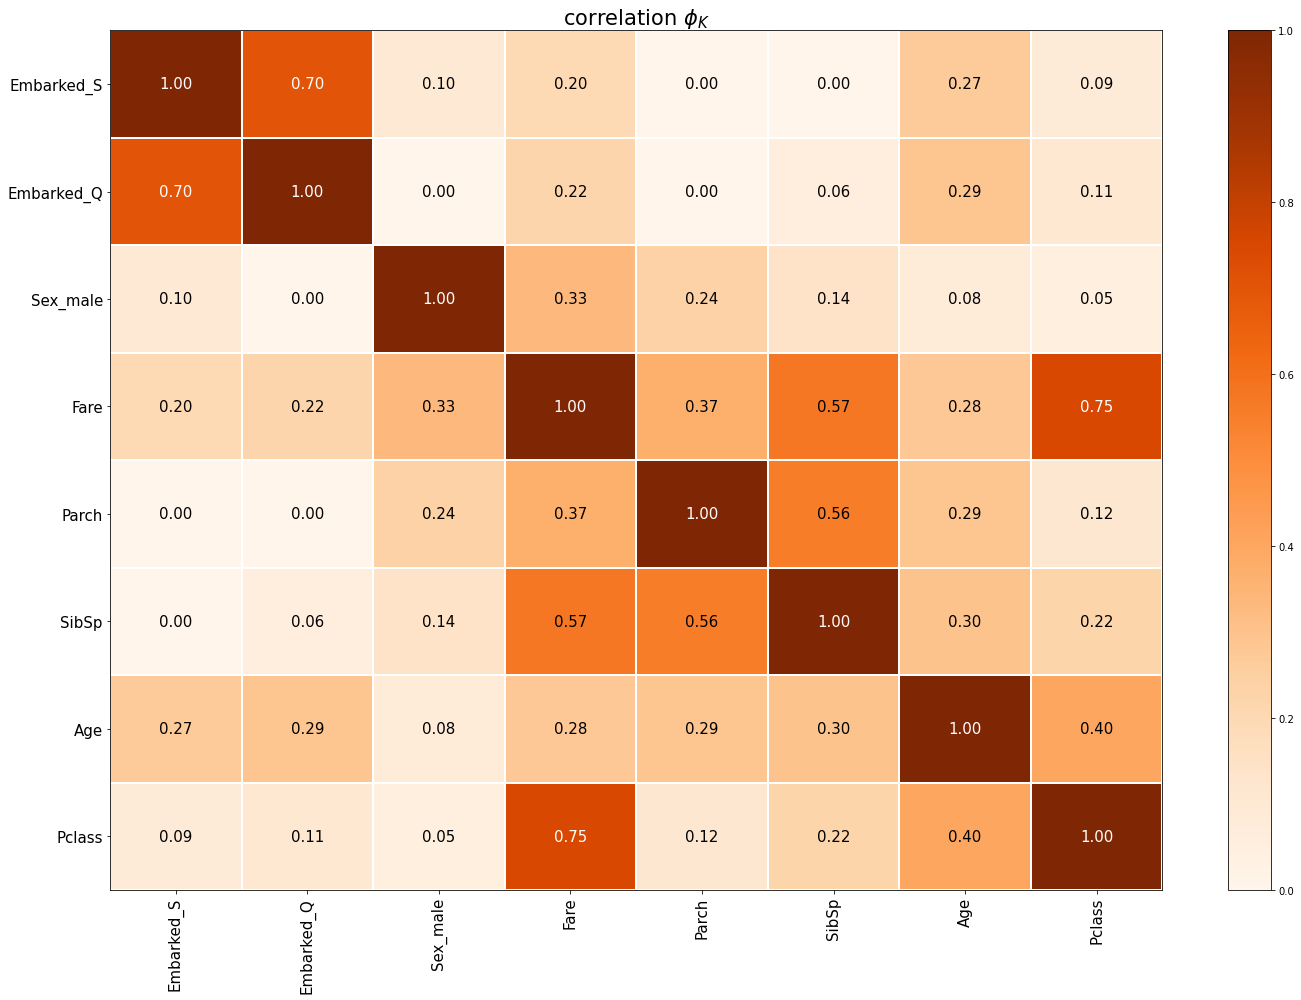

In [37]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                            figsize=(20, 14))
plt.tight_layout()

Как и ранее, сильной корреляции не выявлено. 

## Масштабирование признаков

Нормируем отдельео разбитую на train/valid выборки и отдельно  исходные features

In [38]:
numeric = set(col_cols) - set(['Survived'])

In [39]:
numeric = list(numeric)
numeric

['Fare', 'SibSp', 'Pclass', 'Age', 'Parch']

In [40]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_valid

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
744,0.816439,0.335494,-0.527062,-0.472784,-0.751067,1,0,1
642,0.816439,-1.350845,2.387774,1.962899,0.186633,0,0,1
591,-1.656451,1.556637,0.444550,-0.472784,2.551031,0,0,0
374,0.816439,-1.292696,2.387774,0.745057,-0.133758,0,0,1
102,-1.656451,-0.246002,-0.527062,0.745057,2.505064,1,0,1
...,...,...,...,...,...,...,...,...
383,-1.656451,0.568093,0.444550,-0.472784,1.317975,0,0,1
517,0.816439,-1.525294,-0.527062,-0.472784,0.010594,1,1,0
329,-1.656451,-0.536750,-0.527062,0.745057,1.598661,0,0,0
682,0.816439,-0.304152,-0.527062,-0.472784,-0.690041,1,0,1


## Вывод

1. Было произведено разделение на трейн и валид в отношении 1 к 4, и еще тестовая выборка у нас дана отдельно. 
2. Взаимной коррреляции найдено не было
3. Произведено масштабирование числовых признаков.

# Обучение

## Обучение без подбора гиперпараметров

### Логистическая регрессия

In [41]:
lr =  LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [42]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = lr.predict(X)
  
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1_score(y, pred):.3f}')     
  print(f'ROC_AUC {label}={roc_auc_score(y, lr.predict_proba(X)[:, 1]):.3f}\n')     



Acc train=0.773
F1 train=0.697
ROC_AUC train=0.840

Acc test=0.759
F1 test=0.685
ROC_AUC test=0.795



### Метод ближайших соседей

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [44]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = knn.predict(X)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')
  print(f'F1 {label}={f1_score(y, pred):.3f}')  
  print(f'ROC_AUC {label}={roc_auc_score(y, knn.predict_proba(X)[:, 1]):.3f}\n') 

Acc train=0.841
F1 train=0.780
ROC_AUC train=0.911

Acc test=0.752
F1 test=0.667
ROC_AUC test=0.782



## Обучение с подбором гиперпараметров

### Логистическая регрессия

In [45]:
params = dict(
    C = [100, 10, 1, 0.1, 0.01, 0.001],
    penalty=['l1', 'l2', 'elasticnet'],
    solver=['saga'],
    multi_class =['auto', 'ovr', 'multinomial'],
    l1_ratio=[1]
)

In [46]:
lr = LogisticRegression()
lr = RandomizedSearchCV(lr, params, n_jobs=-1, cv=5, random_state=random_state)
lr.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01, 0.001],
                                        'l1_ratio': [1],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['saga']},
                   random_state=111222)

In [47]:
best_params = lr.best_params_
best_params

{'solver': 'saga',
 'penalty': 'l2',
 'multi_class': 'multinomial',
 'l1_ratio': 1,
 'C': 0.1}

In [48]:
#lr = LogisticRegression(**best_params)
#lr.fit(X_train, y_train)

In [49]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = lr.predict(X)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1_score(y, pred):.3f}')   
  print(f'ROC_AUC {label}={roc_auc_score(y, lr.predict_proba(X)[:, 1]):.3f}\n') 

Acc train=0.782
F1 train=0.704
ROC_AUC train=0.838

Acc test=0.766
F1 test=0.679
ROC_AUC test=0.798



### Метод KNN

In [50]:
params = dict(
    n_neighbors = range(1, 40),
    weights = ['uniform', 'distance'],
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
    p=[1, 2]

)

In [51]:
knn = KNeighborsClassifier()
knn = RandomizedSearchCV(knn, params, n_jobs=-1, cv=5, random_state=random_state)
knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': range(1, 40),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=111222)

In [53]:
best_params = knn.best_params_
best_params

{'weights': 'uniform', 'p': 1, 'n_neighbors': 5, 'algorithm': 'kd_tree'}

In [54]:
#knn = KNeighborsClassifier(**best_params)
#knn.fit(X_train, y_train)

In [55]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = knn.predict(X)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')
  print(f'F1 {label}={f1_score(y, pred):.3f}') 
  print(f'ROC_AUC {label}={roc_auc_score(y, knn.predict_proba(X)[:, 1]):.3f}\n')    

Acc train=0.849
F1 train=0.795
ROC_AUC train=0.920

Acc test=0.752
F1 test=0.667
ROC_AUC test=0.791



### CatBoost

In [56]:
%%time

!pip install catboost
from catboost import CatBoostClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.3 MB/s eta 0:00:00
CPU times: user 211 ms, sys: 43.5 ms, total: 254 ms
Wall time: 11.8 s


In [57]:
cat_cols_boost = ['Sex',	'Embarked']

In [58]:
model = CatBoostClassifier(loss_function='Logloss', 
                               cat_features=cat_cols_boost,
                               eval_metric = 'Accuracy', #:hints=skip_train~false
                               verbose=False)

grid = {'learning_rate': np.linspace(0.01, 0.2, 10),
        'depth': [3, 6],
        'l2_leaf_reg': [2, 5],
        'n_estimators': [200, 300]}

randomized_search_result = model.randomized_search(grid,
                                       X=X_train_cat, 
                                       y=y_train_cat,
                                       stratified = True,
                                       train_size = 0.8,
                                       cv=3,
                                       refit=True,
                                       verbose=500,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8189655172
bestIteration = 74

0:	loss: 0.8189655	best: 0.8189655 (0)	total: 540ms	remaining: 4.86s

bestTest = 0.8017241379
bestIteration = 6


bestTest = 0.8017241379
bestIteration = 99


bestTest = 0.8017241379
bestIteration = 27


bestTest = 0.8448275862
bestIteration = 50


bestTest = 0.8189655172
bestIteration = 13


bestTest = 0.8189655172
bestIteration = 21


bestTest = 0.8362068966
bestIteration = 146


bestTest = 0.8362068966
bestIteration = 11


bestTest = 0.8362068966
bestIteration = 12

9:	loss: 0.8362069	best: 0.8448276 (4)	total: 8.94s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.7823834197
bestIteration = 11

Training on fold [1/3]

bestTest = 0.8134715026
bestIteration = 262

Training on fold [2/3]

bestTest = 0.8115183246
bestIteration = 253



In [59]:
randomized_search_result['params']

{'depth': 6,
 'l2_leaf_reg': 2,
 'iterations': 300,
 'learning_rate': 0.03111111111111111}

In [60]:
best_model = CatBoostClassifier(depth = randomized_search_result['params']['depth'],
                                l2_leaf_reg = randomized_search_result['params']['l2_leaf_reg'], 
                                learning_rate = randomized_search_result['params']['learning_rate'],
                                eval_metric='Accuracy',
                                iterations=200,
                                loss_function= 'Logloss',
                                cat_features=cat_cols_boost,
                                random_seed=random_state,
                                verbose=200)
    
best_model.fit(X_train_cat, y_train_cat)

pred_train = best_model.predict(X_valid_cat)
accuracy_score(y_valid_cat, pred_train)

0:	learn: 0.7885615	total: 3.46ms	remaining: 688ms
199:	learn: 0.8925477	total: 1.04s	remaining: 0us


0.7724137931034483

## Вывод

Видим, что с подбором гиперпараметров метрики незначительно повысислись. 
Accuracy достигает более менее нормальных значений: 0.755 на валидационной выборке у логистичекой регрессии и 0.781 у KNN.

# Проверка на тестовой выборке

In [61]:
df_test = pd.read_csv('/content/drive/MyDrive/1T_sprint_titanic/test.csv')

## Удаление избыточных признаков

In [62]:
df_test = df_test.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin'])
df_test.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [63]:
df_test = df_test[df_test['Embarked'].isna() == False]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 26.1+ KB


Остались пропуски в столбце возраста. И пропусков довольно много. Попробуем что-то с этим сделать. 

## Пропуски в AGE

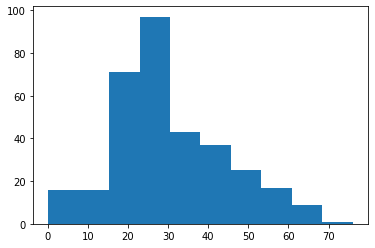

In [64]:
plt.hist(df_test['Age'])
plt.show()

Заменим пропуски в столбце Age на 100.

In [65]:
df_test["Age"] = df_test["Age"].fillna(-1)

In [66]:
df_test["Age"] = df_test['Age'].transform(lambda x: x.round()).astype('int16')

In [67]:
df_test = df_test[df_test['Age'].isna() == False]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int16  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(1), int16(1), int64(3), object(2)
memory usage: 23.7+ KB


## Замена пропуска в Fare

In [68]:
df_test[152:153]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,3,male,60,0,0,NaN,S


In [69]:
df_test.loc[df_test[df_test['Fare'].isna() == True].index, 'Fare'] = 50

In [70]:
df_test = df_test[df_test['Fare'].isna() == False]
#df_test = df_test[df_test['Fare'] < 200]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int16  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(1), int16(1), int64(3), object(2)
memory usage: 23.7+ KB


## Удаление дубликатов

Дубликаты удалять не будем, так как конечный файл загрузки в соревнование должен содержать 418 записей

In [71]:
#df_test= df_test.drop_duplicates()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int16  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(1), int16(1), int64(3), object(2)
memory usage: 23.7+ KB


## Кодирование категориальных признаков

Произведем кодирование категориальных признаков.  Также как в обучающей выборке, создадим копию для CatBoost.

In [72]:
df_test_catboost = df_test.copy()
df_test_catboost.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34,0,0,7.8292,Q
1,3,female,47,1,0,7.0000,S
2,2,male,62,0,0,9.6875,Q
3,3,male,27,0,0,8.6625,S
4,3,female,22,1,1,12.2875,S


In [73]:
df_test = pd.get_dummies(df_test,drop_first=True)
df_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,34,0,0,7.8292,1,1,0
1,3,47,1,0,7.0000,0,0,1
2,2,62,0,0,9.6875,1,1,0
3,3,27,0,0,8.6625,1,0,1
4,3,22,1,1,12.2875,0,0,1


## Масштабирование признаков

In [74]:
df_test[numeric] = scaler.transform(df_test[numeric])
df_test.sample(7)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
296,-0.420006,-1.408995,0.444550,1.962899,0.828785,0,0,0
41,-1.656451,-1.525294,-0.527062,-0.472784,0.123259,1,0,1
24,-1.656451,1.324038,0.444550,3.180741,11.193753,0,0,0
108,0.816439,-1.525294,-0.527062,-0.472784,-0.714099,1,0,1
31,-0.420006,-0.071553,1.416162,-0.472784,0.355630,1,0,1
38,0.816439,-0.013404,-0.527062,-0.472784,-0.677131,1,0,1
311,0.816439,-0.187853,-0.527062,-0.472784,-0.783928,1,0,0


## Вывод

Наши тестовые данные готовы для получения скора

# Получение предсказаний

In [75]:
submission = pd.read_csv('/content/drive/MyDrive/1T_sprint_titanic/gender_submission.csv', index_col = 0)
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  418 non-null    int64
dtypes: int64(1)
memory usage: 6.5 KB


## Предсказания для лучшей модели LR

In [76]:
submission['Survived'] = lr.predict(df_test)
submission.to_csv('my_submission_lr_.csv')

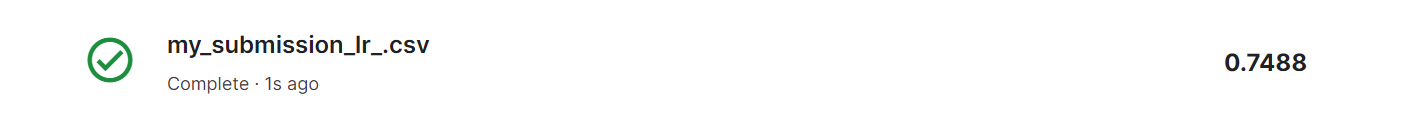

## Предсказания для лучшей модели KNN

In [77]:
submission['Survived'] = knn.predict(df_test)
submission.to_csv('my_submission_knn_.csv')

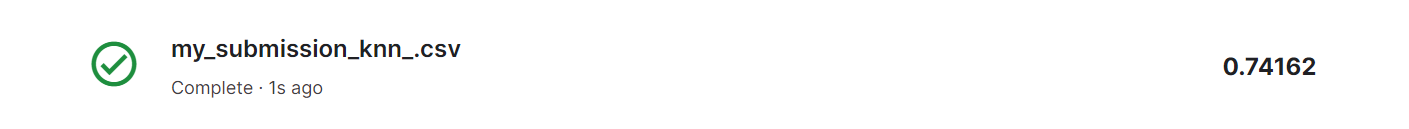

## Предсказания для лучшей модели CatBoost

In [78]:
submission['Survived'] = best_model.predict(df_test_catboost)
submission.to_csv('my_submission_catboost_.csv')


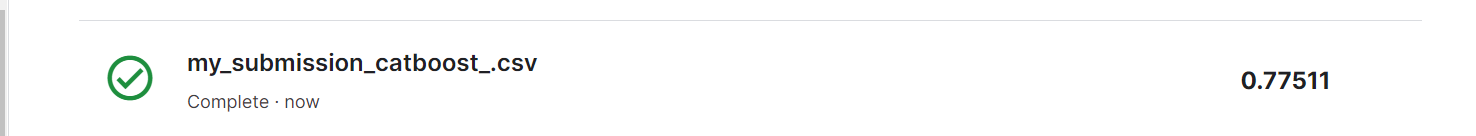

# Вывод

Как можно видеть, после обрубания хвостов (выбросов) в Fare "тяжелая" модель CatBoost дала прирост в скоре по сравнению с простыми моделями: 0.775 Но все равно, думаю, что датасет слишком прост для использования бустинга.

Конечно, можно было бы сделать более хорошую предобработку данных. Так как данных мало и каждый пассажир в целом может иметь значение. 

Лучший скор модели KNN с подбором гиперпараметров: 0.7416. У Логистической регрессии Accuracy = 0.749 на тестовой выборке.